In [22]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
from scipy.optimize import minimize
import matplotlib.ticker as mtick

In [23]:
inicio = dt.date(2013, 1, 2)
final = dt.date(2022, 12, 30)

In [24]:
lista_acoes = ['MGLU3.SA', 'PETR4.SA', 'VALE3.SA', 'ITUB4.SA']
# , 'ELET3.SA', 'LREN3.SA', 'ABEV3.SA', 'BBAS3.SA', 'SUZB3.SA', 'BBDC4.SA'
precos = pd.DataFrame()       
for i in lista_acoes:
    precos[i] = yf.download(i, period='11y')['Adj Close']

precos = precos.drop(index = precos[precos.index.year >= 2023].index)
precos = precos.drop(index = precos[precos.index.year <= 2012].index)

precos

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,MGLU3.SA,PETR4.SA,VALE3.SA,ITUB4.SA
Date,,,,
2013-01-02,0.362282,6.668627,24.720066,10.046229
2013-01-03,0.377225,6.909090,24.299662,10.346332
2013-01-04,0.374970,6.919253,23.924093,10.285149
2013-01-07,0.366229,6.800714,23.453238,10.110328
2013-01-08,0.363692,6.604279,23.268253,10.151124
...,...,...,...,...
2022-12-23,2.680000,20.983215,84.465065,24.558758
2022-12-26,2.660000,20.832857,85.238083,24.071287
2022-12-27,2.520000,20.974861,87.273392,23.934793


In [25]:
retornos = precos.pct_change().apply(lambda x: np.log(1+x)).dropna() # Retorno Logarítmo
media_retornos = retornos.mean()
matriz_cov = retornos.cov()

matriz_cov

,MGLU3.SA,PETR4.SA,VALE3.SA,ITUB4.SA
MGLU3.SA,0.001596,0.000364,0.000254,0.000243
PETR4.SA,0.000364,0.001010,0.000403,0.000373
VALE3.SA,0.000254,0.000403,0.000785,0.000194
ITUB4.SA,0.000243,0.000373,0.000194,0.000424


In [26]:
numero_carteiras = 10000
df_retornos_esperados= np.zeros(numero_carteiras)
df_volatilidades_esperadas = np.zeros(numero_carteiras)
df_sharpe = np.zeros(numero_carteiras)
df_pesos = np.zeros((numero_carteiras, len(lista_acoes)))

for k in range(numero_carteiras):
    
    pesos = np.random.random(len(lista_acoes))
    pesos = pesos / np.sum(pesos)
    df_pesos[k, :] = pesos
    
    df_retornos_esperados[k] = np.sum(media_retornos * pesos * 252)
    df_volatilidades_esperadas[k] = np.sqrt(np.dot(pesos.T, np.dot(matriz_cov*252, pesos)))
    
    df_sharpe[k] = df_retornos_esperados[k] / df_volatilidades_esperadas[k]

In [27]:
indice_sharpe_maximo = df_sharpe.argmax()
df_pesos[indice_sharpe_maximo]

array([0.3200213 , 0.00794616, 0.34833456, 0.32369798])

In [28]:
df_retornos_esperados_arit = np.exp(df_retornos_esperados) - 1
df_retornos_esperados_arit

array([0.14474355, 0.1411231 , 0.13773278, ..., 0.14352248, 0.13446534,
       0.13017036])

In [29]:
eixoY_fronteira_eficiente = np.linspace(df_retornos_esperados_arit.min(),
                                        df_retornos_esperados_arit.max(), 50)

def pegando_retorno(peso_teste):
    peso_teste = np.array(peso_teste)
    retorno = np.sum(media_retornos * peso_teste) * 252
    retorno = np.exp(retorno) - 1
    
    return retorno

def chacando_soma_pesos(peso_teste):
    
    return np.sum(peso_teste) - 1

def pegando_vol(peso_teste):
    peso_teste = np.array(peso_teste)
    vol = df_volatilidades_esperadas[k] = np.sqrt(np.dot(peso_teste.T, np.dot(matriz_cov*252, peso_teste)))
    
    return vol

peso_inicial = [1/len(lista_acoes)] * len(lista_acoes)
limites = tuple([0, 1] for ativo in lista_acoes)

eixoX_fronteira_eficiente = []

for retorno_possivel in eixoY_fronteira_eficiente:
    # Vamos pegar a melhor volatilidade para cada retorno possível
    
    restricoes = ({'type':'eq', 'fun':chacando_soma_pesos},
                 {'type':'eq', 'fun': lambda w: pegando_retorno(w) - retorno_possivel})
    
    result = minimize(pegando_vol, peso_inicial, method='SLSQP', bounds=limites,
                     constraints=restricoes)
    eixoX_fronteira_eficiente.append(result['fun'])

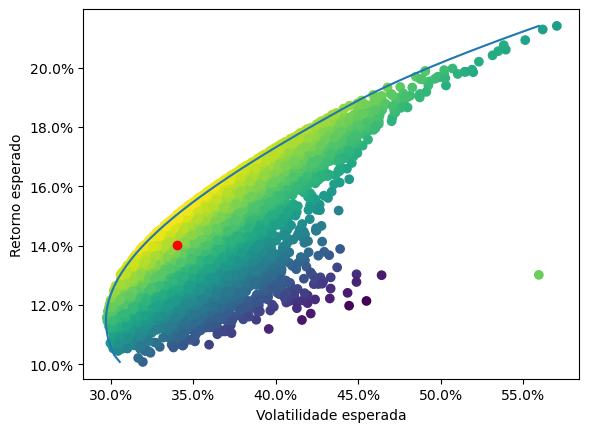

In [30]:
fig, ax = plt.subplots()

ax.scatter(df_volatilidades_esperadas, df_retornos_esperados_arit, c= df_sharpe)
plt.xlabel('Volatilidade esperada')
plt.ylabel('Retorno esperado')
# ax.xaxis.label.set_color('white')
# ax.yaxis.label.set_color('white')
ax.scatter(df_volatilidades_esperadas[indice_sharpe_maximo],
          df_retornos_esperados[indice_sharpe_maximo], c = 'red')
ax.plot(eixoX_fronteira_eficiente, eixoY_fronteira_eficiente)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
# ax.tick_params(axis='y', colors='white')
# ax.tick_params(axis='x', colors='white')

plt.show()